<a href="https://colab.research.google.com/github/bulutirm/RealAndFakeFaceDetection/blob/main/RealAndFakeFaceDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from urllib.request import urlopen

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/real_and_fake_face'

In [ ]:
target_size = (224, 224)

waste_labels = {'training_real' : 0, 'training_fake' : 1}

In [59]:
import shutil

folder_path = '/content/drive/MyDrive/processed_image'  # Silmek istediğiniz klasörün yolunu buraya girin

# Klasörü ve içindeki dosyaları sil
shutil.rmtree(folder_path)

In [58]:
def load_datasets(path):

  labels = []
  x = []
  x_original = []

  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x_original.append(img)
    #img = img.astype(np.float32) / 255.0
    img = cv2.flip(img, 1)  # Yatay olarak yansıtma
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) 
    img = img[:, :, ::-1]
    img = cv2.GaussianBlur(img, (7,7), 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x.append(img)
    
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])


  x_original, labels = shuffle(x_original, labels, random_state=42)
  x, labels = shuffle(x, labels, random_state = 42)

  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} \nGözlem sayısı: {len(labels)}")

  return x, x_original, labels

In [60]:
x, x_original, labels = load_datasets(dir_path)

X boyutu: (2041, 224, 224, 3)
Label sınıf sayısı: 2 
Gözlem sayısı: 2041


In [61]:
input_shape = (np.array(x[0]).shape[1], np.array(x[1]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [62]:
def visualize_img(image_batch, label_batch):
  random_images = np.random.choice(len(image_batch), size=10, replace=False)

  plt.figure(figsize=(10,10))
  for n, random_image in enumerate(random_images, start=0):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=2)[n]==1][0].title())
    plt.axis('off')

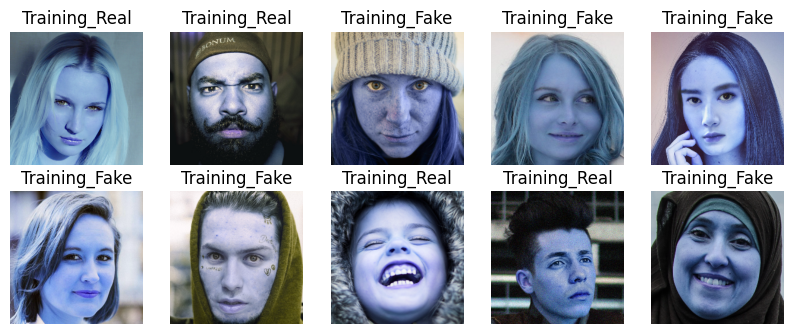

In [63]:
visualize_img(x_original, labels)

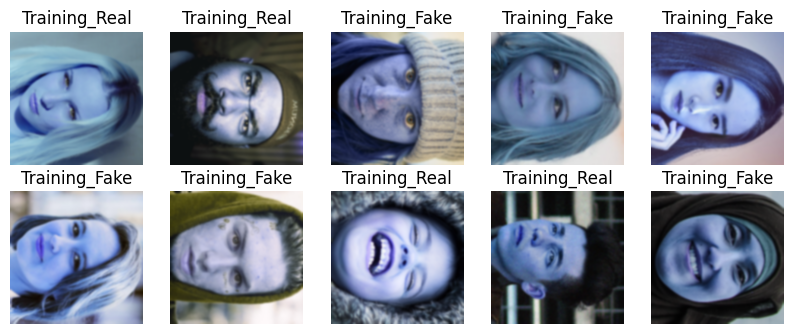

In [64]:
visualize_img(x, labels)

In [55]:
def save_processed_images(x, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for image, label in zip(x, labels):
        class_folder = os.path.join(output_dir, str(label))
        os.makedirs(class_folder, exist_ok=True)
        
        filename = f'image_{str(label)}_{len(os.listdir(class_folder))}.jpg'
        filepath = os.path.join(class_folder, filename)
        cv2.imwrite(filepath, image)

In [65]:
processed_image = '/content/drive/MyDrive/processed_image'

In [66]:
processed_image = save_processed_images(x, labels, processed_image)

In [67]:
#Train veri seti için bir generator tanımlıyoruz
train = ImageDataGenerator(horizontal_flip = True,
                           validation_split = 0.2,
                           rescale = 1./255,
                           shear_range = 0.2,
                           zoom_range = 0.2,
                           width_shift_range = 0.1,
                           height_shift_range = 0.1)

#Test veri seti için bir generator tanımlıyoruz.
test = ImageDataGenerator(rescale = 1/255,
                          validation_split = 0.1)

In [68]:
processed_image = '/content/drive/MyDrive/processed_image'

In [69]:
train_generator = train.flow_from_directory(directory = processed_image,
                                             target_size = (target_size),
                                             class_mode = 'categorical',
                                             subset = 'training')

test_generator = test.flow_from_directory(directory = processed_image,
                                          target_size = (target_size),
                                          batch_size = 251,
                                          class_mode = 'categorical',
                                          subset = 'validation')

Found 1633 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [70]:
#modelleme
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', 
                 input_shape = (input_shape), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=2, activation='softmax'))

In [71]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [72]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

In [73]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=1)]

In [74]:
history = model.fit_generator(generator=train_generator,
                              epochs=30,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=1633//32,
                              validation_steps=204//32)

Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 1.6229 - precision: 0.5066 - recall: 0.5066 - acc: 0.5066
Epoch 1: val_loss improved from inf to 1.65732, saving model to mymodel.h5
51/51 [==============================] - 28s 302ms/step - loss: 1.6229 - precision: 0.5066 - recall: 0.5066 - acc: 0.5066 - val_loss: 1.6573 - val_precision: 0.5539 - val_recall: 0.5539 - val_acc: 0.5539
Epoch 2/30
51/51 [==============================] - ETA: 0s - loss: 0.8721 - precision: 0.5103 - recall: 0.5103 - acc: 0.5103
Epoch 2: val_loss did not improve from 1.65732
51/51 [==============================] - 16s 301ms/step - loss: 0.8721 - precision: 0.5103 - recall: 0.5103 - acc: 0.5103 - val_loss: 1.7860 - val_precision: 0.5098 - val_recall: 0.5098 - val_acc: 0.5098
Epoch 3/30
51/51 [==============================] - ETA: 0s - loss: 0.7343 - precision: 0.5116 - recall: 0.5116 - acc: 0.5116
Epoch 3: val_loss did not improve from 1.65732
51/51 [==============================] - 15s 

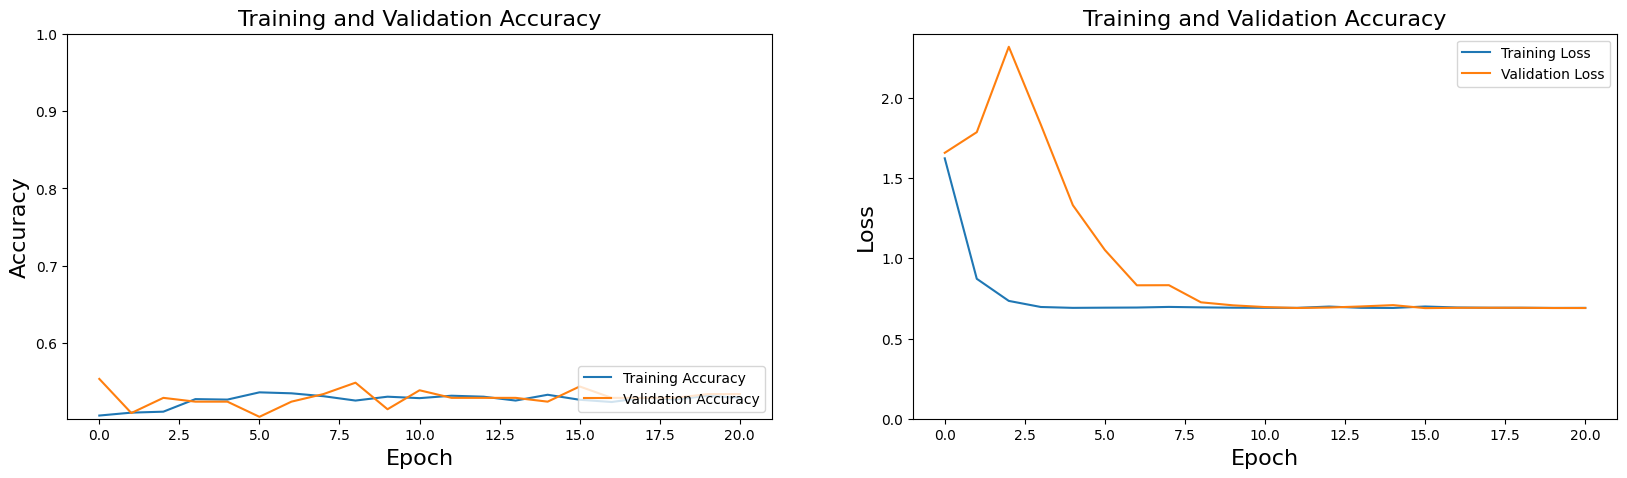

In [75]:
#Accuracy Grafiği

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontsize=16)

#Loss grafiği
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Accuracy', fontsize=16)

plt.show()

In [76]:
loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)

1/1 [==============================] - 1s 728ms/step - loss: 0.6899 - precision: 0.5343 - recall: 0.5343 - acc: 0.5343


In [77]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))


Test accuracy: 53.4%

Test loss: 69.0%

Test precision: 53.4%

Test recall: 53.4%


In [78]:
#Clasification Report
x_test, y_test = test_generator.next()

y_pred = model.predict(x_test)

y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(y_test, axis=1)

7/7 [==============================] - 0s 53ms/step


In [79]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [80]:
target_names = list(waste_labels.keys())

In [81]:
from sklearn.metrics import classification_report

In [82]:
print(classification_report(y_test, y_pred, target_names=target_names))

               precision    recall  f1-score   support

training_real       0.53      1.00      0.69       108
training_fake       1.00      0.01      0.02        96

     accuracy                           0.53       204
    macro avg       0.77      0.51      0.36       204
 weighted avg       0.75      0.53      0.38       204



In [83]:
#Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label', fontweight="bold")
  plt.xlabel('Predicted label', fontweight="bold")

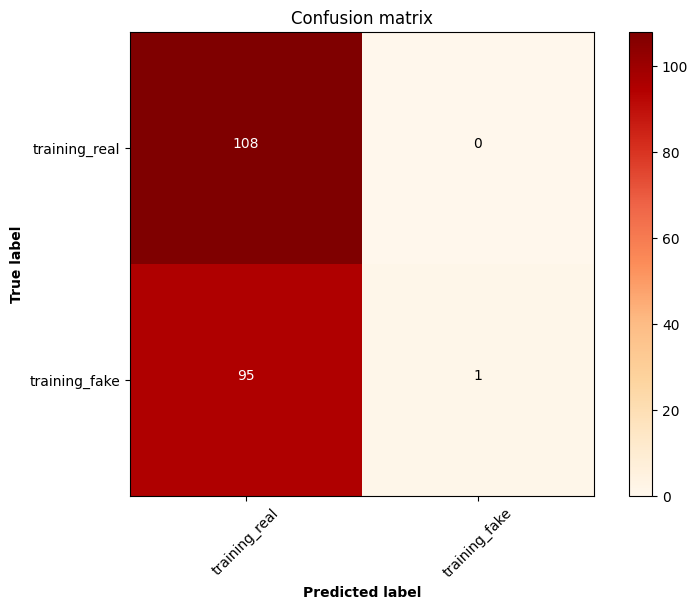

In [84]:
plot_confusion_matrix(cm, waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)